In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [2]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

[b'tweet_tfidf_fit_transform',
 b'tweet_SVD_fit',
 b'temp_hash_count_12hr',
 b'hashtags_tfidf_fit_transform',
 b'hashtags_countvec_fit_temp',
 b'tweet_tfidf_fit',
 b'hashtags_countvec_fit',
 b'hashtag_tfidf',
 b'hashtags_countvec_fit_transform']

In [5]:
TFIDF = pickle.loads(r.get('tweet_tfidf_fit_transform'))
SVD_fit = pickle.loads(r.get('tweet_SVD_fit'))

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
dataset_scaled_pca = pca.fit_transform(TFIDF)
plt.scatter(dataset_scaled_pca[:,0],dataset_scaled_pca[:,1], c=target,cmap='magma')
plt.colorbar()

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [ ]:
logreg = LogisticRegression()
logreg.fit(Xc, y)

In [8]:
def event_tweet_count(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [9]:
def tweets_event_ab_test(event):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',round(a1a2,3),'\n'
                'B1|B2: ',round(b1b2,3), '\n\n'
                'A1|B1: ',round(a1b1,3), '\n'
                'A2|B2: ', round(a2b2,3), '\n\n'
                'Cosine Similarity Mean of A2 to A1', round(a2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to B1', round(b2_mean,3), '\n'
                'Cosine Similarity Mean of B2 to A1', round(a1b2_mean,3), '\n\n'
                'Cosine Similarity STD of A2 to A1', round(a2_std,3), '\n'
                'Cosine Similarity STD of B2 to B1', round(b2_std,3), '\n'
                'Cosine Similarity STD of B2 to A1', round(a1b2_std,3), '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [10]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event = event.lower()
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [11]:
def Top_scored_tweets_in_B(event, n = 10000):
    event = event.lower()
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

Event Tweets (paris|climate):  2627
A1|A2:  0.985 
B1|B2:  0.922 

A1|B1:  0.317 
A2|B2:  0.366 

Cosine Similarity Mean of A2 to A1 0.324 
Cosine Similarity Mean of B2 to B1 0.167 
Cosine Similarity Mean of B2 to A1 0.075 

Cosine Similarity STD of A2 to A1 0.226 
Cosine Similarity STD of B2 to B1 0.131 
Cosine Similarity STD of B2 to A1 0.106 



(-0.1, 1)

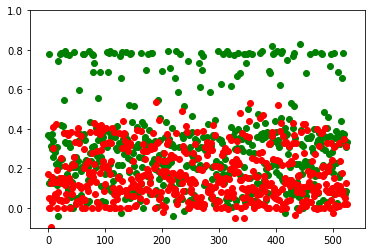

In [15]:
print('Event Tweets (paris|climate): ', event_tweet_count('paris|climate'))
A, B = tweets_event_ab_test('paris|climate')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

In [10]:
check_score_cluster('paris|climate',.3, .7)

,index,score,tweet,index,score,tweet
0,553,0.818651,did they think elon musk would convince trump ...,650,0.349624,ha!!! cares about the environment 🙄🙄appointed ...
1,46,0.801133,"""yesterday trump made one of the most dishones...",74,0.349356,the actual process is long so the us couldn't...
2,1194,0.792826,#andersoncooper on #climate #change: we still ...,1191,0.348971,"“you quit paris, so i quit you” thank you for ..."
3,978,0.791234,leaders of large us cities are bucking trump's...,688,0.348697,"here is one for liberals, democrats &amp; all ..."
4,997,0.790187,only reason trump don't care/believe in climat...,29,0.348087,can richard nixon's ghost go to paris and fix ...
5,584,0.781997,i don't know why everybody is worried about ba...,5,0.347778,knows every language &amp; read all about hum...
6,1269,0.781961,"wow, trump stooped low to cancel #climate agre...",728,0.347146,"not too worried about paris accord, next presi..."
7,361,0.781133,lmao trump and 22 other republican congressman...,48,0.347080,friendly reminder that earth will survive clim...
8,1259,0.778615,"terrorist attack, 7 dead: 'don't panic.' pull ...",1224,0.347031,it was signed in paris!!! it's not -- it doesn...
9,867,0.777970,promises kept &amp; broken:trump's climate agr...,651,0.346826,with all the evidence that we are in a climate...


Event Tweets (nbafinals):  1123
A1|A2:  0.998 
B1|B2:  0.857 

A1|B1:  0.044 
A2|B2:  0.083 

Cosine Similarity Mean of A2 to A1 0.721 
Cosine Similarity Mean of B2 to B1 0.144 
Cosine Similarity Mean of B2 to A1 0.021 

Cosine Similarity STD of A2 to A1 0.278 
Cosine Similarity STD of B2 to B1 0.14 
Cosine Similarity STD of B2 to A1 0.042 



(-0.1, 1.2)

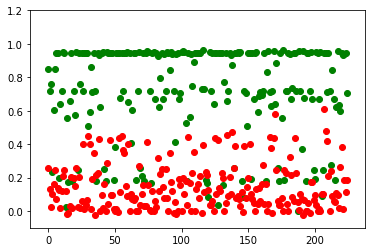

In [11]:
print('Event Tweets (nbafinals): ', event_tweet_count('nbafinals'))
A, B = tweets_event_ab_test('nbafinals')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [12]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('nbafinal',.7)

,index,score,tweet,index,score,tweet
0,193,0.952938,i'm so glad durant is on the #gsw...just cuz i...,158,0.745012,#nbafinals #losangeles private l.a. courier $2...
1,269,0.951059,think #lebronjames wished #cavaliers traded #k...,203,0.744883,looked like the warriors were getting all the ...
2,457,0.950870,"curry takes lebron to the hoop: ""this is where...",53,0.744406,the women of house curry are all fine! #nbafinals
3,103,0.949309,best play of the finals !!! in yo face lebron!...,510,0.742782,cleveland in big trouble. lebron came out on f...
4,205,0.947236,#lebron getting stomped by #durant and #curry ...,195,0.742419,so this was supposed to be the most anticipate...
5,252,0.944427,damn steph schoolin' lebron to the hole. #game...,104,0.742061,"yep! hey nba fans, you got your super team. ho..."
6,248,0.943604,reporter: if there was one thing that stands o...,139,0.736403,"late to tweet, but warriors in 7...although i ..."
7,341,0.943514,and take ur l's like a man #nbafinals #goldens...,253,0.736393,now the big question is will #lebron join the ...
8,135,0.943500,"kd clutch , lebron takes another l #nbafinals",36,0.734804,lebron vs the warriors! #nbafinals
9,388,0.943500,"kd clutch , lebron takes another l #nbafinals",340,0.734039,amazing d by lebron on that 3 pointer by duran...


In [13]:
check_score_cluster('nbafinal',.2)

,index,score,tweet,index,score,tweet
0,519,0.958303,i'm so glad durant is on the #gsw...just cuz i...,442,0.240332,i don't like lebron but yal ain't got to keep ...
1,351,0.956358,think #lebronjames wished #cavaliers traded #k...,366,0.236000,worriers for the win! and here come the lebro...
2,124,0.952841,#lebron getting stomped by #durant and #curry ...,561,0.228867,cavs racking up frequent flyer miles with how ...
3,275,0.950540,damn steph schoolin' lebron to the hole. #game...,144,0.226858,the wrath of god is coming to golden state aft...
4,91,0.949999,i told you before that kd has the most pressur...,14,0.226132,the fact that lebron can't even stampede his w...
5,68,0.949623,that kd 3 in lebron's face was the defining pl...,25,0.225569,well if lebron loses this series he can just j...
6,315,0.949542,reporter: if there was one thing that stands o...,90,0.225143,i knew y'all were gonna make memes // gifs of ...
7,387,0.949447,"kd clutch , lebron takes another l #nbafinals",248,0.225000,this #nbafinals2017 blows help us #lebron -- ...
8,328,0.948437,i feel like durants hard foul on lebron there ...,165,0.224186,"what an ending. dubs, baby!!! #nbafinals2017 #..."
9,127,0.948093,two hot nights for durant. give the man the fi...,517,0.223390,really hope they win ✨ #goldenstate #nbafinals...


Event Tweets (travel ban|travelban):  199
A1|A2:  0.98 
B1|B2:  0.726 

A1|B1:  0.066 
A2|B2:  0.093 

Cosine Similarity Mean of A2 to A1 0.754 
Cosine Similarity Mean of B2 to B1 0.114 
Cosine Similarity Mean of B2 to A1 0.015 

Cosine Similarity STD of A2 to A1 0.249 
Cosine Similarity STD of B2 to B1 0.179 
Cosine Similarity STD of B2 to A1 0.08 



(-0.1, 1.2)

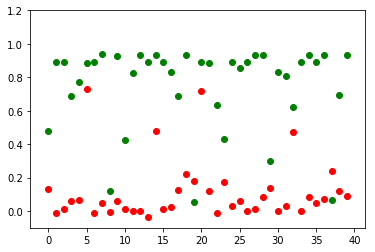

In [14]:
print('Event Tweets (travel ban|travelban): ', event_tweet_count('travel ban|travelban'))
A, B = tweets_event_ab_test('travel ban|travelban')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [15]:
check_score_cluster('travel ban|travelban',.7)

,index,score,tweet,index,score,tweet
0,33,0.937504,how can a travel ban demonize anything what i...,47.0,0.726504,should endorse his travel ban so what happens...
1,15,0.933867,the 90 day travel ban you tried to enact four...,65.0,0.716704,think has it wrong then just take a look at wh...
2,11,0.930533,so it’s definitely a travel ban on muslims cc:...,25.0,0.710745,travel ban is stupid and will do nothing. ter...
3,2,0.930015,"what a dumb fu travel ban, guess the scotus wi...",37.0,0.684802,#cnn already pounding trump tweet to encourage...
4,17,0.930005,he used his tweet to discuss his travel ban. ...,46.0,0.664998,how has said absolute nothing re orlando shoot...
5,41,0.929950,i have supported the travel ban a long. i tru...,32.0,0.652805,this travel ban does nothing for america but ...
6,56,0.929801,these terrorist sympathizers speaking out aga...,45.0,0.652777,wake up america! temporary travel ban
7,29,0.929443,i do not support the travel ban.,NaN,NaN,NaN
8,91,0.929360,stupid reporter.. your damn straight is speak...,NaN,NaN,NaN
9,95,0.929344,"for being such macho, gun-toting men, repubs a...",NaN,NaN,NaN


Event Tweets (nationaldonutday):  527
A1|A2:  0.997 
B1|B2:  0.785 

A1|B1:  0.07 
A2|B2:  0.091 

Cosine Similarity Mean of A2 to A1 0.807 
Cosine Similarity Mean of B2 to B1 0.146 
Cosine Similarity Mean of B2 to A1 0.022 

Cosine Similarity STD of A2 to A1 0.259 
Cosine Similarity STD of B2 to B1 0.155 
Cosine Similarity STD of B2 to A1 0.03 



(-0.1, 1.2)

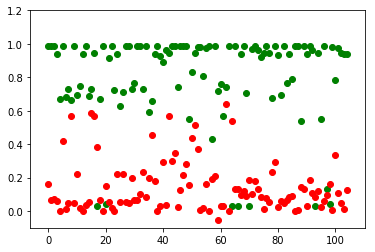

In [16]:
print('Event Tweets (nationaldonutday): ', event_tweet_count('nationaldonutday'))
A, B = tweets_event_ab_test('nationaldonutday')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [17]:
Top_scored_tweets_in_B('nbafinals', n = 300000)

,score,tweet
237635,0.791969,jungkook and jimin
197661,0.791969,admitting to psychological struggles period is not weakness.
154000,0.791969,latvians my draft specialty.
26242,0.791969,please draft
64093,0.791969,on draft [now] •
79966,0.791969,draft him then!?
159232,0.791969,sleeper in the draft
123688,0.791969,bathing whilst on my period. a literal #bloodbath
29850,0.791969,"""what's due next period """
297559,0.791969,sneezing on your period


In [18]:
Top_scored_tweets_in_B('nationaldonutday', n = 300000)

,score,tweet
253186,0.977974,that's what it's for... to hold churros
99821,0.977772,"""lonely hearts 3️⃣"""
55559,0.977772,lonely hearts
70476,0.977772,heartened and comforted now-(for i saw the decisiveness in your hearts to do so l…
147781,0.977772,in our hearts z
213535,0.977735,the #salesforceohana hearts you! so well deserved!
241222,0.976051,turbulent hearts @ redwood.
153264,0.962331,now led tedious shy lasting females off
271482,0.962331,passage its ten led hearted removal cordial
206333,0.962331,passage its ten led hearted removal cordial


In [19]:
Top_scored_tweets_in_B('travel Ban|travelban', n = 300000)

,score,tweet
272237,0.968844,lately all i wanna do is go faster
182340,0.968844,cheaper option
119333,0.968844,was faster than
192584,0.968844,faster than ever before!
98977,0.968844,go faster! ___________ * * * * *
220446,0.968844,hey why not call out the on his claim of and being cheaper? dump the subsidies the…
162116,0.968821,"yep, cheaper and cleaner."
142282,0.961407,italy
219531,0.947349,it melts faster that way
92312,0.939528,it's cheaper to just be yourself


In [20]:
Top_scored_tweets_in_B('paris|climate', n = 300000)

,score,tweet
172925,0.825045,"i wonder if donald trump kids ever been out turning up &amp; heard ""fuck donald trump"" in some lyrics."
159800,0.824423,a domestic terrorist/trump supporter murders 2 innocent americans coming 2 a rescue n portland &amp; trump-bots r quiet/fuck double standards.
38861,0.824260,immigration enforcement feels more racist under trump but it has always been a form of violence &amp; trump has not yet eclipsed obama's numbers
257932,0.823529,terrorists want trump's muslim ban because it will drive recruitment. trump &amp; co want terrorists to keep us scared to drive votes.
10600,0.823393,sampling of reaction so far to #comeyhearing: trump supporters: he's exonerated trump opponents: he obstructed justice &amp; lied
32271,0.823189,but trump &amp; his thug attorneys r kings of the lifetime nda. trump ruins people who expose him. i'm su…
295904,0.822717,"wrong again. the left created the association game, demanding trump denounce ppl, etc. now trump &amp; followers just u…"
266152,0.818567,"comey was vindicated....trump obstructed justice. many senators speak on that....""trump is a pathological liar!"" impeach &amp; lock up trump!"
62531,0.818301,"good. so since ur a trump troll &amp; i block trump trolls, i'll be blocking u."
13032,0.812296,"if you know me i don't say the word ""hate"" very often. don't remember the last time i said it out loud, but i hate trump‼️ ok-better now."
